<h1 align = 'center'> Part 1: Transfer Learning for image data using CNN </h1>

## 1. Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import os

## 2. Data Paths

In [ ]:
train_path = "/content/drive/MyDrive/AML_Assignment_5/dataset/train"
val_path = "/content/drive/MyDrive/AML_Assignment_5/dataset/val"
test_path = "/content/drive/MyDrive/AML_Assignment_5/dataset/test"

## 3. Transforms and Dataloaders

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

## 4. Load pre-trained ResNet18 and fine-tune last layer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace last layer (fc) for binary classification
model.fc = nn.Linear(model.fc.in_features, 1)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 5. Training setup

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

## 6. Training Loop

In [ ]:
train_acc_list = []
val_acc_list = []

def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate(model, val_loader)

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


## 7. Validation Function

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            preds = torch.round(torch.sigmoid(outputs))
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


## 8. Train the model

In [ ]:
train_model(model, train_loader, val_loader, epochs=15)

Epoch 1/15 | Loss: 25.6735 | Train Acc: 0.8094 | Val Acc: 0.9006
Epoch 2/15 | Loss: 15.1047 | Train Acc: 0.9220 | Val Acc: 0.9130
Epoch 3/15 | Loss: 13.9243 | Train Acc: 0.9309 | Val Acc: 0.9130
Epoch 4/15 | Loss: 12.8430 | Train Acc: 0.9342 | Val Acc: 0.9130
Epoch 5/15 | Loss: 11.3572 | Train Acc: 0.9409 | Val Acc: 0.9130
Epoch 6/15 | Loss: 10.2281 | Train Acc: 0.9320 | Val Acc: 0.9193
Epoch 7/15 | Loss: 8.3006 | Train Acc: 0.9554 | Val Acc: 0.9193
Epoch 8/15 | Loss: 10.7528 | Train Acc: 0.9443 | Val Acc: 0.9255
Epoch 9/15 | Loss: 9.7613 | Train Acc: 0.9543 | Val Acc: 0.9193
Epoch 10/15 | Loss: 9.5568 | Train Acc: 0.9387 | Val Acc: 0.9193
Epoch 11/15 | Loss: 7.8152 | Train Acc: 0.9443 | Val Acc: 0.9068
Epoch 12/15 | Loss: 7.0372 | Train Acc: 0.9565 | Val Acc: 0.9193
Epoch 13/15 | Loss: 11.0456 | Train Acc: 0.9509 | Val Acc: 0.9255
Epoch 14/15 | Loss: 6.5382 | Train Acc: 0.9610 | Val Acc: 0.9255
Epoch 15/15 | Loss: 6.7194 | Train Acc: 0.9576 | Val Acc: 0.9255


## 9. Plot of Train Accuracy Vs Validation Accuracy

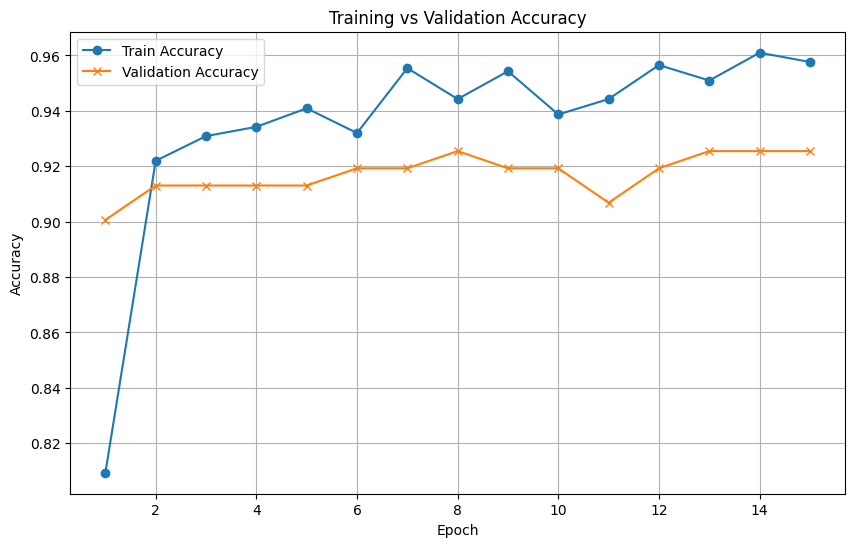

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_acc_list) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_acc_list, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## 10. Evaluation on Test Set

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=['chicken', 'duck']))


              precision    recall  f1-score   support

     chicken       0.97      0.94      0.96       172
        duck       0.97      0.98      0.98       310

    accuracy                           0.97       482
   macro avg       0.97      0.96      0.97       482
weighted avg       0.97      0.97      0.97       482



## 11. Overall Precision, Recall, F1-score, Accuracy

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)

print(f"✅ Overall Accuracy:  {accuracy:.4f}")
print(f"✅ Overall Precision: {precision:.4f}")
print(f"✅ Overall Recall:    {recall:.4f}")
print(f"✅ Overall F1-score:  {f1:.4f}")

✅ Overall Accuracy:  0.9689
✅ Overall Precision: 0.9683
✅ Overall Recall:    0.9839
✅ Overall F1-score:  0.9760
